## Step 1: Setup and Configuration
This section imports all necessary libraries and defines robust, absolute paths to our data and model directories. Using absolute paths is a best practice that prevents errors when running code from different locations or using background workers.

In [61]:
import os
import json
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms
from torchvision.models import efficientnet_b2
from sklearn.metrics import classification_report, confusion_matrix

In [62]:
# Paths
root_path = os.path.join('..', 'dataset', 'malaria')
train_json_path = os.path.join(root_path, 'training.json')
test_json_path = os.path.join(root_path, 'test.json')
image_path = os.path.join(root_path, 'images')
models_dir = os.path.join('.', 'efficientnet_models')

os.makedirs(models_dir, exist_ok=True) # Create directory if it doesn't exist

print("Root Path:", root_path)
print("Train JSON Path:", train_json_path)
print("Test JSON Path:", test_json_path)
print("Image Path:", image_path)

Root Path: ..\dataset\malaria
Train JSON Path: ..\dataset\malaria\training.json
Test JSON Path: ..\dataset\malaria\test.json
Image Path: ..\dataset\malaria\images


## Step 2: Model and Dataset Definitions
Here we define the core components: the `MalariaDataset` class to load our specific JSON format, the `EfficientNetDetector` model, and our custom loss functions.

In [63]:
class MalariaDataset(Dataset):
    def __init__(self, json_path, image_root, transform=None, category_map=None):
        with open(json_path, 'r') as f:
            self.entries = json.load(f)
        self.image_root = image_root
        self.transform = transform

        if category_map is None:
            all_categories = set()
            for item in self.entries:
                for obj in item['objects']:
                    all_categories.add(obj['category'])
            self.category_map = {cat: idx for idx, cat in enumerate(sorted(list(all_categories)))}
        else:
            self.category_map = category_map
        
        self.labels = []
        for item in self.entries:
            if item['objects']:
                cat = item['objects'][0]['category']
                self.labels.append(self.category_map[cat])
            else:
                self.labels.append(-1)

    def __len__(self):
        return len(self.entries)

    def __getitem__(self, idx):
        entry = self.entries[idx]
        pathname_from_json = entry['image']['pathname']
        image_name = os.path.basename(pathname_from_json)
        image_full_path = os.path.join(self.image_root, image_name)

        try:
            image = Image.open(image_full_path).convert("RGB")
        except FileNotFoundError:
            print(f"Error: Image not found at {image_full_path}")
            return None # Will be filtered by collate_fn

        boxes = []
        labels = []
        for obj in entry['objects']:
            bb = obj['bounding_box']
            boxes.append([bb['minimum']['c'], bb['minimum']['r'], bb['maximum']['c'], bb['maximum']['r']])
            labels.append(self.category_map[obj['category']])

        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)

        if self.transform:
            image = self.transform(image)

        target = {'boxes': boxes, 'labels': labels}
        return image, target

class EfficientNetDetector(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.backbone = efficientnet_b2(weights='IMAGENET1K_V1')
        num_features = self.backbone.classifier[1].in_features
        self.backbone.classifier = nn.Identity()
        self.classifier = nn.Linear(num_features, num_classes)
        self.bbox_head = nn.Linear(num_features, 4)

    # In your EfficientNetDetector class...
    def forward(self, x):
        features = self.backbone(x)
        class_scores = self.classifier(features)
        
        # Apply a sigmoid to constrain the bbox output to be between 0 and 1
        bbox_preds = torch.sigmoid(self.bbox_head(features))
        
        return class_scores, bbox_preds

# Custom collate_fn to filter out None values from the batch (e.g., from missing images)
def custom_collate_fn(batch):
    batch = list(filter(lambda x: x is not None, batch))
    if not batch:
        return torch.tensor([]), []
    images = [item[0] for item in batch]
    targets = [item[1] for item in batch]
    images = torch.stack(images, dim=0)
    return images, targets

## Step 3: Training and Validation Functions
This is the core logic. `train_model` handles one epoch of training. The `validate_model` function is crucially important and contains the **new, robust logic** to generate a fair, image-level ground truth for the final classification report.

In [64]:
def train_model(model, loader, optimizer, device, epoch, num_classes):
    model.train()
    running_loss, correct, total_objects = 0.0, 0, 0
    pbar = tqdm(loader, desc=f"Training Epoch {epoch}")

    # These loss functions must be defined to be used
    # def margin_loss(class_scores, targets, margin=0.2):
    #     one_hot_targets = F.one_hot(targets.long(), num_classes=class_scores.size(-1)).float()
    #     left = F.relu(margin - class_scores) * one_hot_targets
    #     right = F.relu(class_scores - (1 - margin)) * (1.0 - one_hot_targets)
    #     return (left + right).sum(dim=-1).mean()

    # def bbox_loss(preds, targets):
    #     return F.smooth_l1_loss(preds, targets)
    
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)

    for images, targets_list in pbar:
        if not images.numel(): continue # Skip empty batches
        images = images.to(device)
        optimizer.zero_grad()
        class_scores, bbox_preds = model(images)
        
        # batch_class_loss = 0
        # batch_bbox_loss = 0
        # image_size = images.shape[-1]

        # for i in range(images.size(0)):
        #     target = targets_list[i]
        #     target_boxes = target['boxes'].to(device)
        #     target_labels = target['labels'].to(device)
            
        #     if len(target_labels) == 0: continue

        #     batch_class_loss += margin_loss(class_scores[i].unsqueeze(0), target_labels)
            
        #     # For bbox loss, we only compare against the first object's box for simplicity
        #     target_box_norm = target_boxes[0] / torch.tensor([image_size, image_size, image_size, image_size], device=device)
        #     batch_bbox_loss += bbox_loss(bbox_preds[i], target_box_norm)
            
        #     predicted = torch.argmax(class_scores[i])
        #     correct += (predicted == target_labels).sum().item()
        #     total_objects += len(target_labels)
            
        # loss = batch_class_loss + 0.1 * batch_bbox_loss
        # if total_objects > 0:
        #     loss.backward()
        #     optimizer.step()
        #     running_loss += loss.item()
        
        # pbar.set_postfix(loss=f"{loss.item():.4f}")
        # ... inside the 'for images, targets_list in pbar:' loop ...
        # Create a placeholder for all target labels in the batch
        all_target_labels = torch.zeros_like(class_scores).to(device)

        # Populate the multi-hot encoded tensor
        for i, target in enumerate(targets_list):
            labels = target['labels']
            if len(labels) > 0:
                all_target_labels[i, labels] = 1.0

        # Calculate loss for the whole batch at once
        loss = criterion(class_scores, all_target_labels)

        if images.size(0) > 0:
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # --- New Accuracy Calculation ---
        # Apply sigmoid to get probabilities, then threshold to get predictions
        preds = torch.sigmoid(class_scores)
        preds[preds >= 0.5] = 1
        preds[preds < 0.5] = 0

        # Compare if the predicted multi-hot vector exactly matches the true one
        total_objects += images.size(0)
        correct += (preds == all_target_labels).all(dim=1).sum().item()

        pbar.set_postfix(loss=f"{loss.item():.4f}")

    epoch_loss = running_loss / len(loader) if len(loader) > 0 else 0
    accuracy = 100 * correct / total_objects if total_objects > 0 else 0
    return epoch_loss, accuracy

def validate_model(model, loader, device, num_classes, category_map, return_preds=False):
    model.eval()
    all_labels_for_report = []
    all_preds_for_report = []
    pbar = tqdm(loader, desc="Validating")

    # Invert map to get name from index
    idx_to_category = {v: k for k, v in category_map.items()}
    # Get the integer labels for non-parasite classes
    non_parasite_labels = {category_map[cat] for cat in ['red blood cell', 'leukocyte', 'difficult'] if cat in category_map}

    with torch.no_grad():
        # for images, targets_list in pbar:
        #     if not images.numel(): continue
        #     images = images.to(device)
        #     class_scores, _ = model(images)

        #     for i in range(images.size(0)):
        #         target_labels = targets_list[i]['labels']
        #         if len(target_labels) == 0: continue

        #         predicted_idx = torch.argmax(class_scores[i]).item()
        #         all_preds_for_report.append(predicted_idx)

        #         # --- ROBUST LOGIC FOR TRUE LABEL --- 
        #         parasite_labels = [lbl.item() for lbl in target_labels if lbl.item() not in non_parasite_labels]
                
        #         if parasite_labels:
        #             true_label_for_report = parasite_labels[0]
        #         else:
        #             true_label_for_report = target_labels[0].item()
                
        #         all_labels_for_report.append(true_label_for_report)
        # ... inside the 'with torch.no_grad():' block ...
        for images, targets_list in pbar:
            if not images.numel(): continue
            images = images.to(device)
            class_scores, _ = model(images)

            # Get predictions by applying sigmoid and a 0.5 threshold
            preds = torch.sigmoid(class_scores)
            preds[preds >= 0.5] = 1
            preds[preds < 0.5] = 0
            all_preds_for_report.extend(preds.cpu().numpy())

            # Create the true multi-hot labels for the batch
            true_labels = torch.zeros_like(preds)
            for i, target in enumerate(targets_list):
                labels = target['labels']
                if len(labels) > 0:
                    true_labels[i, labels] = 1.0
            all_labels_for_report.extend(true_labels.cpu().numpy())

    if return_preds:
        return all_labels_for_report, all_preds_for_report
    else:
        # Return overall accuracy if not doing a detailed report
        accuracy = 100 * np.mean(np.array(all_labels_for_report) == np.array(all_preds_for_report))
        return accuracy

## Step 4: Main Training Pipeline
This is where we put everything together. We'll define our hyperparameters, set up the datasets and dataloaders, and then run the training loop for a set number of epochs. After training, the best model is saved.

In [65]:
# --- 1. Define Hyperparameters for our single run ---
params = {
    'lr': 0.001,
    'optimizer': 'Adam',
    'batch_size': 32,
    'image_size': 224,
    'sampling': 'oversample' # Use oversampling to help with imbalance
}
NUM_EPOCHS = 1
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# --- 2. Create Datasets and Category Map ---
transform = transforms.Compose([
    transforms.Resize((params['image_size'], params['image_size'])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_ds = MalariaDataset(train_json_path, image_path, transform=transform)
category_map = train_ds.category_map
num_classes = len(category_map)
test_ds = MalariaDataset(test_json_path, image_path, transform=transform, category_map=category_map)

print(f"Found {num_classes} classes: {category_map}")



# Place this code before your training loop
print("Calculating class weights for the loss function...")

# Count the occurrences of each class (positives)
# We build a multi-hot matrix for the whole dataset
multi_hot_labels = np.zeros((len(train_ds), num_classes), dtype=float)
for i, entry in enumerate(train_ds.entries):
    for obj in entry['objects']:
        cat_idx = category_map.get(obj['category'])
        if cat_idx is not None:
            multi_hot_labels[i, cat_idx] = 1.0

# Sum over the dataset to get positive counts for each class
positive_counts = multi_hot_labels.sum(axis=0)

# Calculate total number of samples
total_samples = len(train_ds)

# Calculate pos_weight for each class
# Add a small epsilon (1e-6) to avoid division by zero for classes that might not appear
pos_weight = (total_samples - positive_counts) / (positive_counts + 1e-6)

# Convert to a PyTorch tensor
pos_weight_tensor = torch.tensor(pos_weight, dtype=torch.float).to(DEVICE)

print(f"Calculated pos_weight: {pos_weight_tensor.cpu().numpy()}")

Using device: cpu
Found 7 classes: {'difficult': 0, 'gametocyte': 1, 'leukocyte': 2, 'red blood cell': 3, 'ring': 4, 'schizont': 5, 'trophozoite': 6}
Calculating class weights for the loss function...
Calculated pos_weight: [ 2.5321636  7.882353  11.851064   0.         3.9508197  6.6942673
  1.0268457]


In [66]:
# --- 3. Create DataLoaders (with optional oversampling) ---

# OLD
# sampler = None
# if params['sampling'] == 'oversample':
#     print("Applying weighted random oversampling...")
#     class_counts = np.bincount(train_ds.labels)
#     class_weights = 1. / class_counts
#     sample_weights = np.array([class_weights[t] for t in train_ds.labels])
#     sampler = WeightedRandomSampler(torch.from_numpy(sample_weights).double(), len(sample_weights))

# train_loader = DataLoader(
#     train_ds, 
#     batch_size=params['batch_size'], 
#     sampler=sampler,
#     collate_fn=custom_collate_fn,
#     # Set shuffle=False when using a sampler
#     shuffle=sampler is None 
# )

# test_loader = DataLoader(
#     test_ds, 
#     batch_size=params['batch_size'], 
#     shuffle=False, 
#     collate_fn=custom_collate_fn
# )

# NEW
# --- 3. Create DataLoaders (with optional oversampling) ---
sampler = None
if params['sampling'] == 'oversample':
    print("Applying weighted random oversampling...")
    
    # --- THIS IS THE CORRECTED LOGIC ---
    # Get counts for each class. `minlength` ensures the array has a slot for every class.
    # We also filter out the `-1` labels for images that have no objects.
    class_counts = np.bincount(
        [label for label in train_ds.labels if label != -1], 
        minlength=num_classes
    )
    
    # Add a small epsilon (1e-6) to the denominator to prevent division by zero.
    class_weights = 1. / (class_counts + 1e-6)
    
    # Create sample weights, giving a weight of 0 to images with no objects.
    sample_weights = np.array([class_weights[t] if t != -1 else 0 for t in train_ds.labels])
    
    sampler = WeightedRandomSampler(torch.from_numpy(sample_weights).double(), len(sample_weights))
    # --- END OF CORRECTION ---

train_loader = DataLoader(
    train_ds,
    batch_size=params['batch_size'],
    # sampler=sampler,  <-- REMOVE OR COMMENT THIS OUT
    collate_fn=custom_collate_fn,
    shuffle=True  # <-- SET SHUFFLE TO TRUE since the sampler is gone
)

test_loader = DataLoader(
    test_ds, 
    batch_size=params['batch_size'], 
    shuffle=False, 
    collate_fn=custom_collate_fn
)

# --- 4. Initialize Model and Optimizer ---
model = EfficientNetDetector(num_classes=num_classes).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'])

# --- 5. Run Training Loop ---
best_val_accuracy = 0.0
history = {'train_loss': [], 'train_accuracy': [], 'val_accuracy': []}

for epoch in range(1, NUM_EPOCHS + 1):
    train_loss, train_acc = train_model(model, train_loader, optimizer, DEVICE, epoch, num_classes)
    val_acc = validate_model(model, test_loader, DEVICE, num_classes, category_map)
    
    history['train_loss'].append(train_loss)
    history['train_accuracy'].append(train_acc)
    history['val_accuracy'].append(val_acc)
    
    print(f"Epoch {epoch} Summary: Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")
    
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        save_path = os.path.join(models_dir, 'best_model.pth')
        torch.save(model.state_dict(), save_path)
        print(f"🎉 New best model saved to {save_path} with accuracy: {best_val_accuracy:.2f}%")

print("\n--- Training Complete ---")

Applying weighted random oversampling...


Validating: 100%|██████████| 4/4 [00:11<00:00,  2.87s/it]

Epoch 1 Summary: Train Acc: 6.13%, Val Acc: 66.67%
🎉 New best model saved to .\efficientnet_models\best_model.pth with accuracy: 66.67%

--- Training Complete ---


## Step 5: Final Evaluation and Analysis
Now that the model is trained, we load the best-performing version (the one saved during the epoch with the highest validation accuracy) and run a final, detailed evaluation on the test set. This gives us an unbiased assessment of its performance.

In [67]:
print("--- Starting Final Evaluation on Test Set ---")

# --- 1. Load the Best Model State ---
best_model_path = os.path.join(models_dir, 'best_model.pth')
eval_model = EfficientNetDetector(num_classes=num_classes).to(DEVICE)
eval_model.load_state_dict(torch.load(best_model_path, map_location=DEVICE))
print(f"Loaded best model from {best_model_path}")

# --- 2. Get Final Predictions ---
y_true, y_pred = validate_model(eval_model, test_loader, DEVICE, num_classes, category_map, return_preds=True)

# --- 3. Generate Reports ---
class_names = [name for name, index in sorted(category_map.items(), key=lambda item: item[1])]
labels_for_report = list(range(len(class_names)))

# Classification Report
print("\n--- Classification Report ---")
report = classification_report(
    y_true, 
    y_pred, 
    target_names=class_names,
    labels=labels_for_report,
    zero_division=0
)
print(report)

--- Starting Final Evaluation on Test Set ---


C:\Users\shera\AppData\Local\Temp\ipykernel_12524\2222583317.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  eval_model.load_state_dict(torch.load(best_model_path, map_l

Loaded best model from .\efficientnet_models\best_model.pth


Validating: 100%|██████████| 4/4 [00:13<00:00,  3.32s/it]


--- Classification Report ---
                precision    recall  f1-score   support

     difficult       0.00      0.00      0.00         5
    gametocyte       0.00      0.00      0.00        11
     leukocyte       0.00      0.00      0.00         0
red blood cell       1.00      0.29      0.45       120
          ring       0.36      0.37      0.37        57
      schizont       0.07      0.33      0.12         9
   trophozoite       0.00      0.00      0.00        59

     micro avg       0.43      0.23      0.30       261
     macro avg       0.21      0.14      0.13       261
  weighted avg       0.54      0.23      0.29       261
   samples avg       0.35      0.23      0.27       261




--- Per-Class Confusion Matrices ---


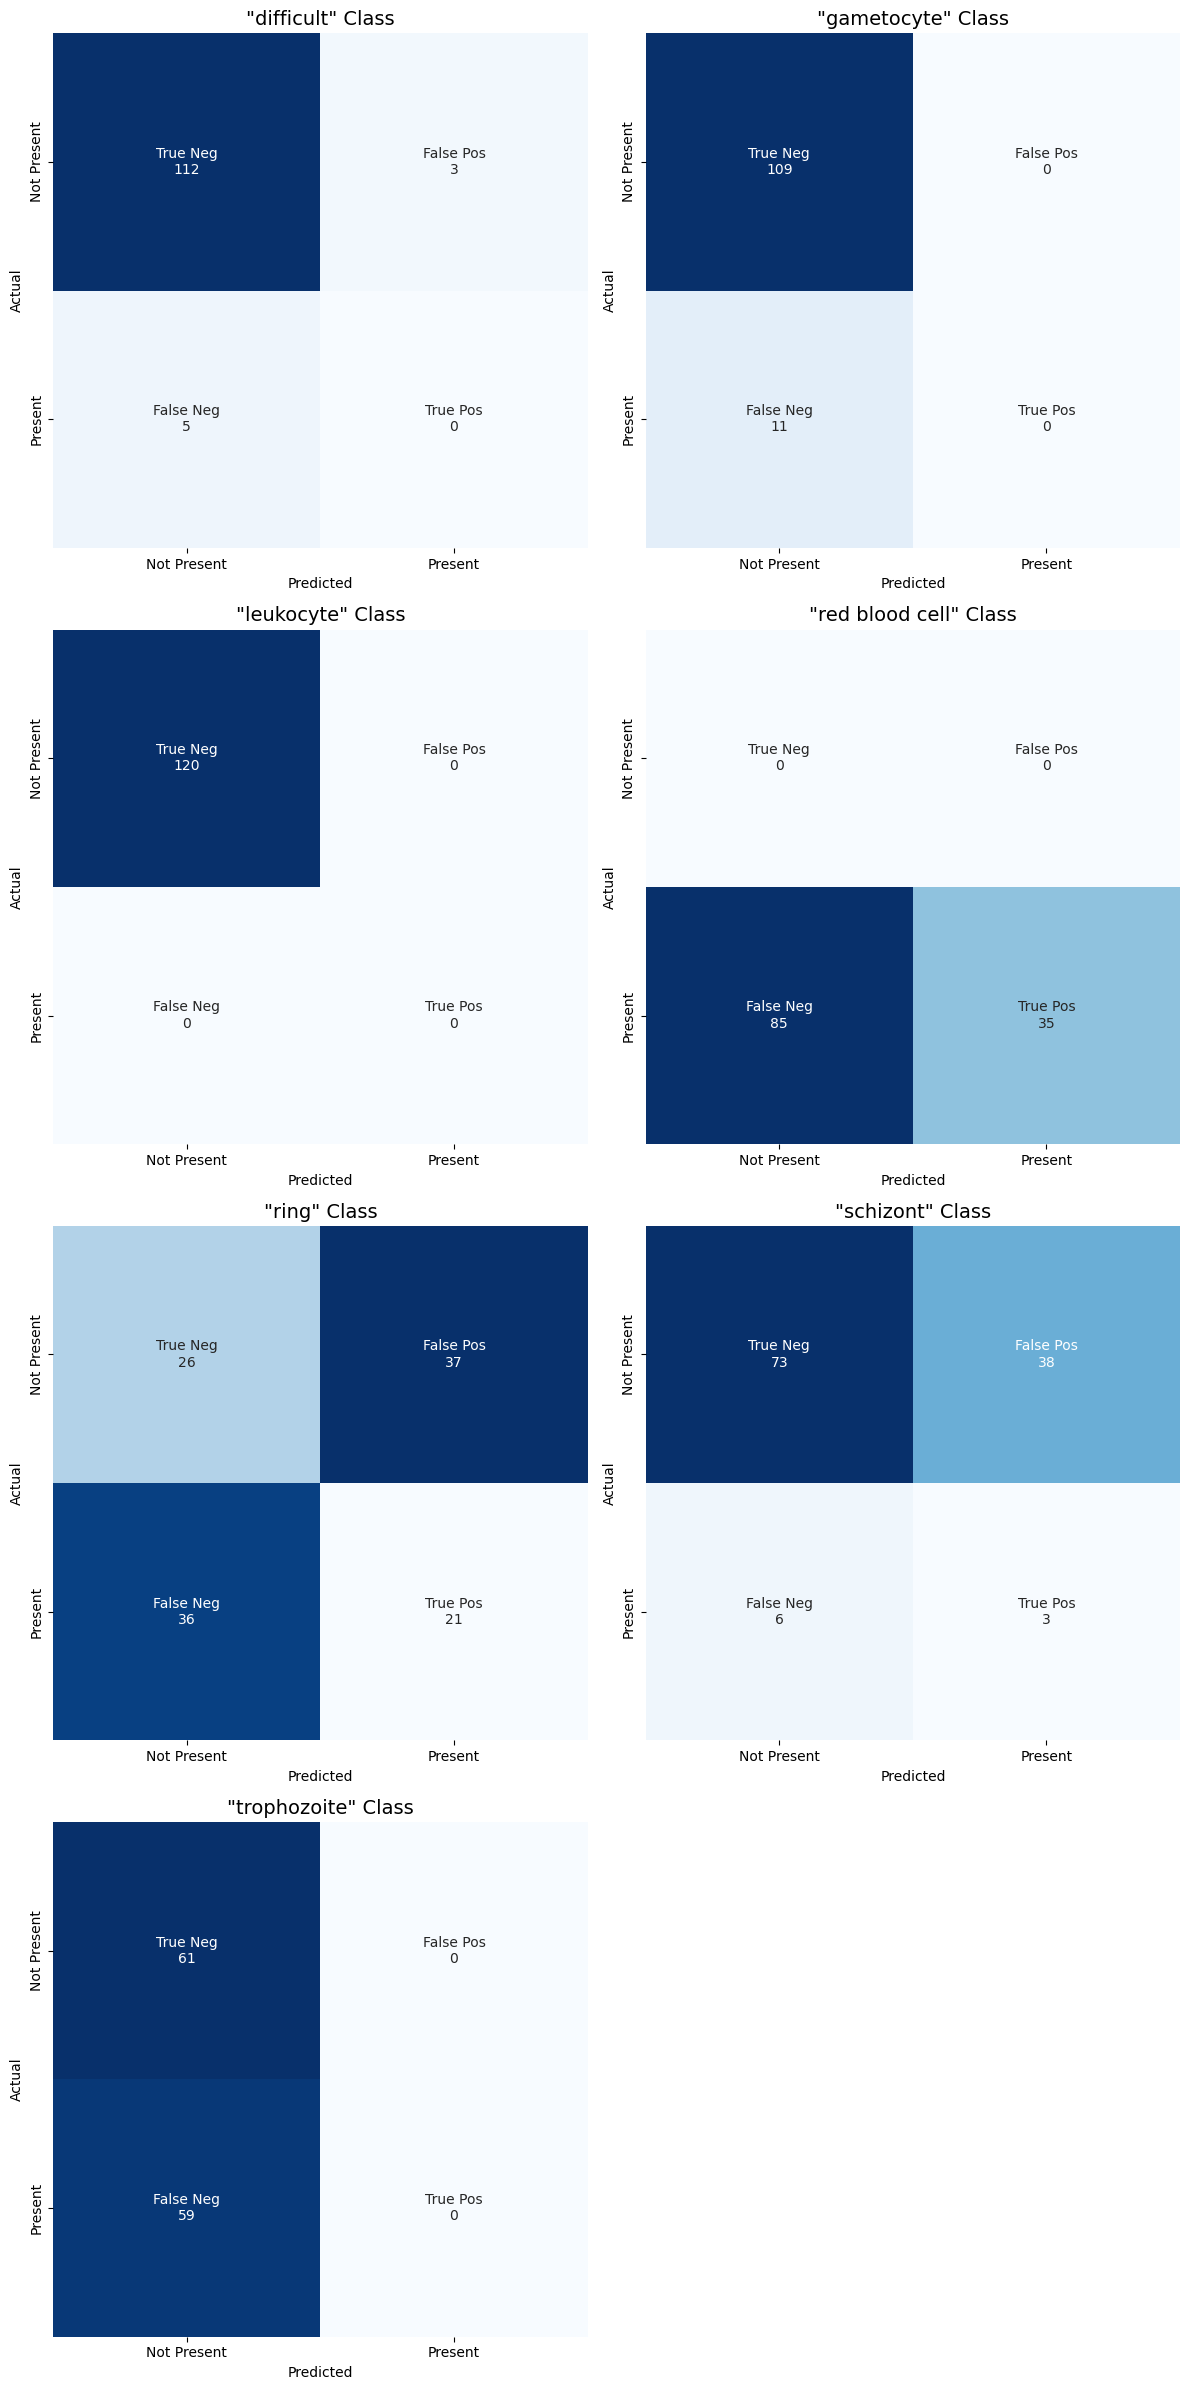

In [68]:
from sklearn.metrics import multilabel_confusion_matrix

# --- 1. Generate the multi-label confusion matrices ---
mcm = multilabel_confusion_matrix(y_true, y_pred, labels=labels_for_report)

# --- 2. Plot a confusion matrix for each class ---
print("\n--- Per-Class Confusion Matrices ---")
# Create a subplot for each class
# Adjust nrows and ncols based on how many classes you have
nrows = (len(class_names) + 1) // 2
fig, axes = plt.subplots(nrows=nrows, ncols=2, figsize=(12, nrows * 6))
axes = axes.flatten() # Flatten the axes array for easy iteration

for i, class_name in enumerate(class_names):
    ax = axes[i]
    # Get the 2x2 matrix for the current class
    matrix = mcm[i]
    
    # Format the labels for the heatmap
    group_counts = [f"{value}" for value in matrix.flatten()]
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names, group_counts)]
    labels = np.asarray(labels).reshape(2,2)
    
    sns.heatmap(matrix, annot=labels, fmt='', cmap='Blues', ax=ax, cbar=False)
    ax.set_title(f'"{class_name}" Class', fontsize=14)
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')
    ax.set_xticklabels(['Not Present', 'Present'])
    ax.set_yticklabels(['Not Present', 'Present'])

# Hide any unused subplots
for i in range(len(class_names), len(axes)):
    fig.delaxes(axes[i])
    
plt.tight_layout()
plt.show()

### Model prediction

In [75]:
# --- 1. SETUP ---
# Ensure all your class definitions (EfficientNetDetector, MalariaDataset) are in memory

# Define the path to your best model
best_model_path = os.path.join(models_dir, 'best_model.pth')
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- 2. GET THE CATEGORY MAP AND CLASS NAMES ---
# We need the exact same mapping from training to translate the model's output
# (This assumes train_json_path and image_path are already defined)
temp_train_ds = MalariaDataset(train_json_path, image_path)
category_map = temp_train_ds.category_map
num_classes = len(category_map)
class_names = [name for name, index in sorted(category_map.items(), key=lambda item: item[1])]

print(f"Loaded class names: {class_names}")

# --- 3. LOAD THE TRAINED MODEL ---
model = EfficientNetDetector(num_classes=num_classes).to(DEVICE)
model.load_state_dict(torch.load(best_model_path, map_location=DEVICE))
model.eval() # Set the model to evaluation mode

print(f"\nModel loaded from {best_model_path} and is ready for inference.")

Loaded class names: ['difficult', 'gametocyte', 'leukocyte', 'red blood cell', 'ring', 'schizont', 'trophozoite']

Model loaded from .\efficientnet_models\best_model.pth and is ready for inference.


C:\Users\shera\AppData\Local\Temp\ipykernel_12524\1697708285.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path, map_locat

--- Processing image: fed6ba05-36a5-45dc-a4e1-9baa7de2c622.png ---

--- Prediction Breakdown ---
All Class Scores:
  - ring           : 59.60%
  - red blood cell : 24.19%
  - difficult      : 6.19%
  - trophozoite    : 4.43%
  - schizont       : 4.03%
  - gametocyte     : 1.39%
  - leukocyte      : 0.18%

Predicted BBox (x_min, y_min, width, height): [416.67, 431.14, 885.37, 588.80]


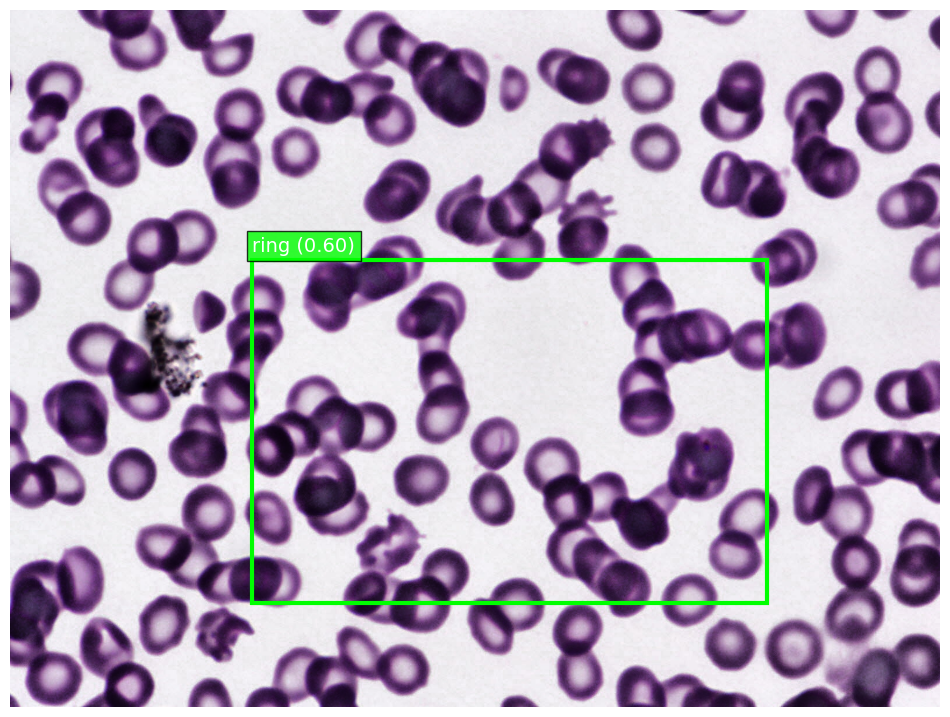

In [76]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

def visualize_prediction(model, image_path, device, class_names, threshold=0.5, force_draw=False):
    """
    Makes a prediction, prints the full class score breakdown, and visualizes the result.
    """
    print(f"--- Processing image: {os.path.basename(image_path)} ---")
    image_pil = Image.open(image_path).convert("RGB")
    
    # Preprocess the image
    transform = transforms.Compose([
        transforms.Resize((224, 224)), # Must match training image size
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image_tensor = transform(image_pil).unsqueeze(0).to(device)

    # Make prediction
    with torch.no_grad():
        class_scores, bbox_preds = model(image_tensor)

    # Decode prediction
    probabilities = F.softmax(class_scores[0], dim=0)
    
    # --- NEW: Get scores for ALL classes ---
    # Create a list of (class_name, probability) tuples
    all_scores = []
    for i, class_name in enumerate(class_names):
        all_scores.append((class_name, probabilities[i].item()))
        
    # Sort the scores from highest to lowest
    sorted_scores = sorted(all_scores, key=lambda x: x[1], reverse=True)
    
    # The top score is our winner
    predicted_label, confidence = sorted_scores[0]
    
    # --- ALWAYS PRINT THE FULL BREAKDOWN ---
    print("\n--- Prediction Breakdown ---")
    # Print the full list of scores
    print("All Class Scores:")
    for class_name, score in sorted_scores:
        print(f"  - {class_name:<15}: {score*100:.2f}%")

    # Denormalize bounding box coordinates
    normalized_bbox = bbox_preds[0].cpu().numpy()
    original_width, original_height = image_pil.size
    
    center_x = normalized_bbox[0] * original_width
    center_y = normalized_bbox[1] * original_height
    box_width = normalized_bbox[2] * original_width
    box_height = normalized_bbox[3] * original_height
    
    x_min = center_x - (box_width / 2)
    y_min = center_y - (box_height / 2)

    print(f"\nPredicted BBox (x_min, y_min, width, height): [{x_min:.2f}, {y_min:.2f}, {box_width:.2f}, {box_height:.2f}]")

    # --- VISUALIZE THE RESULTS ---
    if confidence >= threshold or force_draw:
        if force_draw and confidence < threshold:
            print("\nNOTE: Forcing draw of low-confidence box (in red).")
        
        fig, ax = plt.subplots(1, figsize=(12, 12))
        ax.imshow(image_pil)
        
        box_color = 'lime' if confidence >= threshold else 'red'
        rect = patches.Rectangle((x_min, y_min), box_width, box_height, linewidth=3, edgecolor=box_color, facecolor='none')
        ax.add_patch(rect)
        
        label_text = f"{predicted_label} ({confidence:.2f})"
        ax.text(x_min, y_min - 15, label_text, color='white', fontsize=14, 
                bbox=dict(facecolor=box_color, alpha=0.8))
        
        ax.axis('off')
        plt.show()
    else:
        print(f"\nConfidence ({confidence*100:.2f}%) is below the {threshold*100}% threshold. Box not drawn.")
        print("Set `force_draw=True` in the function call to see it anyway.")


# --- HOW TO USE IT ---
# Specify the path to an image you want to test
my_image_path = os.path.join(image_path, 'fed6ba05-36a5-45dc-a4e1-9baa7de2c622.png')

# This assumes 'eval_model', 'DEVICE', and 'class_names' are already loaded
visualize_prediction(
    model=eval_model, 
    image_path=my_image_path,
    device=DEVICE,
    class_names=class_names,
    threshold=0.5,
    force_draw=True 
)

Prediction complete. Found: 'ring' with 59.60% confidence.


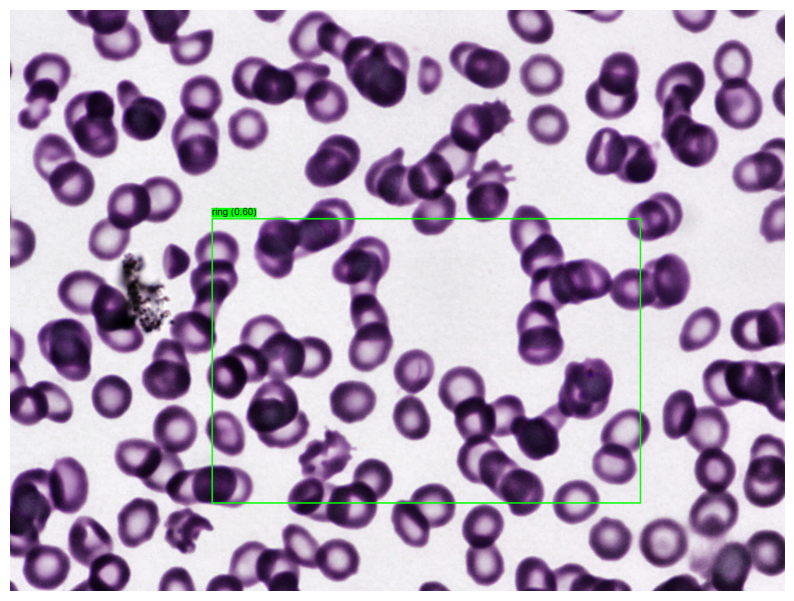

In [71]:
# --- Specify the path to an image you want to test ---
# Make sure this image is in the correct directory
my_image_path = os.path.join(image_path, 'fed6ba05-36a5-45dc-a4e1-9baa7de2c622.png')

# --- Run the prediction and display the result ---
if os.path.exists(my_image_path):
    result_image = predict_and_visualize(
        model=model,
        image_path=my_image_path,
        device=DEVICE,
        class_names=class_names,
        threshold=0.5 # Optional: only show predictions with >50% confidence
    )

    # Display the image
    plt.figure(figsize=(10, 10))
    plt.imshow(result_image)
    plt.axis('off')
    plt.show()
else:
    print(f"Error: Image not found at {my_image_path}")

In [79]:
# Create a single dictionary to hold all ground truth entries
all_entries_map = {}

# Populate the map from the training dataset
for entry in train_ds.entries:
    filename = os.path.basename(entry['image']['pathname'])
    all_entries_map[filename] = entry

# Add/overwrite with entries from the test dataset
for entry in test_ds.entries:
    filename = os.path.basename(entry['image']['pathname'])
    all_entries_map[filename] = entry

print(f"Created a lookup map with {len(all_entries_map)} total unique image entries.")

Created a lookup map with 1328 total unique image entries.


In [95]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import torch
import torch.nn.functional as F
from torchvision import transforms
import os
import numpy as np
from collections import Counter # <-- Import Counter

def visualize_prediction_with_ground_truth(
    model, image_path, all_entries_map, device, class_names, threshold=0.5
):
    """
    Makes a prediction and displays it side-by-side with the ground truth,
    including a frequency count of ground truth classes.
    """
    print(f"--- Processing image: {os.path.basename(image_path)} ---")
    image_pil = Image.open(image_path).convert("RGB")
    
    # --- 1. Find the Ground Truth data using the lookup map ---
    target_filename = os.path.basename(image_path)
    ground_truth_entry = all_entries_map.get(target_filename)

    # --- 2. Preprocess the image and make a prediction ---
    # (This section is unchanged)
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image_tensor = transform(image_pil).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        class_scores, bbox_preds = model(image_tensor)

    # --- 3. Decode the Multi-Label Prediction ---
    # (This section is unchanged)
    probabilities = torch.sigmoid(class_scores[0])
    predicted_indices = (probabilities >= threshold).nonzero(as_tuple=True)[0]
    
    print("\n--- Prediction Breakdown ---")
    all_scores = sorted([(class_names[i], probabilities[i].item()) for i in range(len(class_names))], key=lambda x: x[1], reverse=True)
    for class_name, score in all_scores:
        print(f"  - {class_name:<15}: {score*100:.2f}%")

    # --- 4. Create the side-by-side plot ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

    # --- Plot 1: Model Prediction ---
    # (This section is unchanged)
    ax1.imshow(image_pil)
    ax1.set_title('Model Prediction', fontsize=16)
    ax1.axis('off')
    if len(predicted_indices) > 0:
        normalized_bbox = bbox_preds[0].cpu().numpy()
        w, h = image_pil.size
        center_x, center_y, box_w, box_h = normalized_bbox * np.array([w, h, w, h])
        x_min, y_min = center_x - (box_w / 2), center_y - (box_h / 2)
        rect = patches.Rectangle((x_min, y_min), box_w, box_h, linewidth=3, edgecolor='lime', facecolor='none')
        ax1.add_patch(rect)
        label_texts = [f"{class_names[i]} ({probabilities[i]:.2f})" for i in predicted_indices]
        ax1.text(x_min, y_min - 15, "\n".join(label_texts), color='white', fontsize=12,
                 bbox=dict(facecolor='lime', alpha=0.8, edgecolor='none'))
    else:
        ax1.text(0.5, 0.5, 'No predictions above threshold', color='white', fontsize=14, ha='center', va='center',
                 bbox=dict(facecolor='red', alpha=0.7, edgecolor='none'), transform=ax1.transAxes)

    # --- Plot 2: Ground Truth ---
    ax2.imshow(image_pil)
    ax2.axis('off')

    if ground_truth_entry and ground_truth_entry['objects']:
        # *** NEW: Count and display class frequencies in the title ***
        gt_labels = [obj['category'] for obj in ground_truth_entry['objects']]
        frequency_counts = Counter(gt_labels)
        
        title_str = "Ground Truth Frequency\n"
        sorted_freq = sorted(frequency_counts.items(), key=lambda item: item[1], reverse=True)
        for class_name, count in sorted_freq:
            title_str += f"\n- {class_name}: {count}"
        
        ax2.set_title(title_str, fontsize=14, loc='left')
        # *** END OF NEW CODE ***

        # This part for drawing boxes remains the same
        for obj in ground_truth_entry['objects']:
            bb = obj['bounding_box']
            x_min_gt, y_min_gt = bb['minimum']['c'], bb['minimum']['r']
            width_gt = bb['maximum']['c'] - x_min_gt
            height_gt = bb['maximum']['r'] - y_min_gt
            
            rect_gt = patches.Rectangle((x_min_gt, y_min_gt), width_gt, height_gt, linewidth=3, edgecolor='gold', facecolor='none')
            ax2.add_patch(rect_gt)
            ax2.text(x_min_gt, y_min_gt - 15, obj['category'], color='black', fontsize=12,
                     bbox=dict(facecolor='gold', alpha=0.8, edgecolor='none'))
    else:
        ax2.set_title('Ground Truth Labels', fontsize=16)
        ax2.text(0.5, 0.5, 'No ground truth objects listed', color='white', fontsize=14, ha='center', va='center',
                 bbox=dict(facecolor='gray', alpha=0.7, edgecolor='none'), transform=ax2.transAxes)

    plt.tight_layout()
    plt.show()

--- Processing image: fed6ba05-36a5-45dc-a4e1-9baa7de2c622.png ---

--- Prediction Breakdown ---
  - ring           : 70.15%
  - red blood cell : 48.82%
  - difficult      : 19.61%
  - trophozoite    : 14.86%
  - schizont       : 13.72%
  - gametocyte     : 5.19%
  - leukocyte      : 0.72%


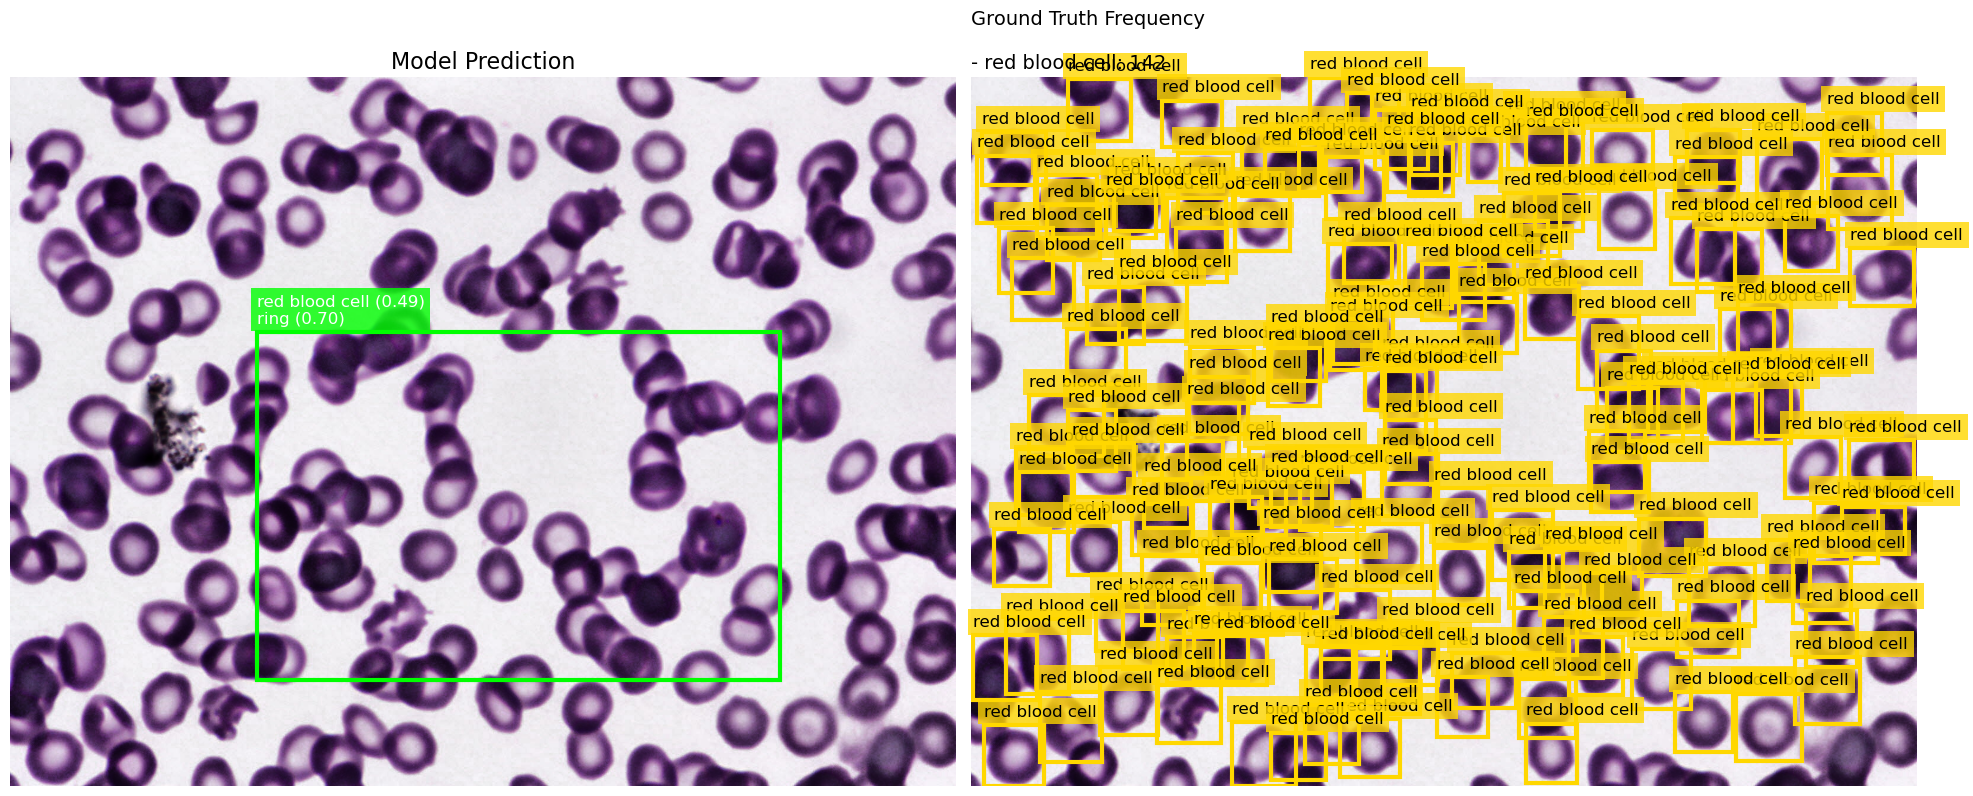

In [96]:
# --- HOW TO USE IT (REVISED) ---
my_image_path = os.path.join(image_path, 'fed6ba05-36a5-45dc-a4e1-9baa7de2c622.png')

visualize_prediction_with_ground_truth(
    model=eval_model,
    image_path=my_image_path,
    all_entries_map=all_entries_map,  # Pass the new map here
    device=DEVICE,
    class_names=class_names,
    threshold=0.4
)

In [73]:
from PIL import Image, ImageDraw, ImageFont

def predict_and_show_box(model, image_path, device, class_names, threshold=0.5):
    """
    Loads an image, makes a prediction, ALWAYS prints the coordinates, 
    and draws the bounding box if confidence is high enough.
    """
    print(f"--- Processing image: {os.path.basename(image_path)} ---")
    
    # 1. Load and preprocess the image
    image_pil = Image.open(image_path).convert("RGB")
    
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image_tensor = transform(image_pil).unsqueeze(0).to(device)

    # 2. Make a prediction
    with torch.no_grad():
        class_scores, bbox_preds = model(image_tensor)

    # 3. Decode the output for the report
    probabilities = F.softmax(class_scores[0], dim=0)
    confidence = probabilities.max().item()
    predicted_idx = probabilities.argmax().item()
    predicted_label = class_names[predicted_idx]

    # --- 4. ALWAYS PRINT THE PREDICTION BREAKDOWN ---
    print("\n--- Prediction Breakdown ---")
    print(f"Predicted Class: '{predicted_label}'")
    print(f"Confidence Score: {confidence:.4f} ({confidence*100:.2f}%)")

    # --- 5. ALWAYS PRINT THE BOUNDING BOX COORDINATES ---
    normalized_bbox = bbox_preds[0].cpu().numpy()
    original_width, original_height = image_pil.size
    
    center_x_norm, center_y_norm, width_norm, height_norm = normalized_bbox
    
    # Denormalize to pixel values
    center_x = center_x_norm * original_width
    center_y = center_y

In [74]:
# --- Specify the path to an image you want to test ---
my_image_path = os.path.join(image_path, '41be1bd3-0d31-4881-bf1f-3ccdfa21ff12.jpg')

# --- Run the prediction and display the result ---
if os.path.exists(my_image_path):
    # Call the new function
    result_image = predict_and_show_box(
        model=model, # Assumes your loaded model is named 'model'
        image_path=my_image_path,
        device=DEVICE,
        class_names=class_names, # Assumes your class_names list is defined
        threshold=0.5 # You can lower this to 0.2 if you want to see the box for your 23.98% prediction
    )

    # Display the image (it will show the box if confidence was high enough)
    plt.figure(figsize=(10, 10))
    plt.imshow(result_image)
    plt.axis('off')
    plt.show()
else:
    print(f"Error: Image not found at {my_image_path}")

--- Processing image: 41be1bd3-0d31-4881-bf1f-3ccdfa21ff12.jpg ---

--- Prediction Breakdown ---
Predicted Class: 'ring'
Confidence Score: 0.5626 (56.26%)


UnboundLocalError: cannot access local variable 'center_y' where it is not associated with a value